In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from utils import *
from estimators import estimate_mutual_information

In [3]:
# define the dimension of the Gaussian
from tqdm import tqdm
dim = 20

# define the training procedure

CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
    'club_gaus':CLUB_layers,
    'l1out':L1OutUB,
    'vub':VarUB
}

BASELINES = {
    'constant': lambda: None,
    'unnormalized': lambda: mlp(dim=dim, hidden_dim=512, output_dim=1, layers=2, activation='relu'),
    'gaussian': lambda: log_prob_gaussian,
}


def train_estimator(critic_params, data_params, mi_params, opt_params, **kwargs):
    """Main training loop that estimates time-varying MI."""
    # Ground truth rho is only used by conditional critic
    critic = CRITICS[mi_params.get('critic', 'separable')](
        **critic_params)
    #print(critic)
    baseline = BASELINES[mi_params.get('baseline', 'constant')]()

    opt_crit = optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])
    if isinstance(baseline, nn.Module):
        opt_base = optim.Adam(baseline.parameters(),
                              lr=opt_params['learning_rate'])
    else:
        opt_base = None

    def train_step(rho, data_params, mi_params):
        # Annoying special case:
        # For the true conditional, the critic depends on the true correlation rho,
        # so we rebuild the critic at each iteration.
        opt_crit.zero_grad()
        if isinstance(baseline, nn.Module):
            opt_base.zero_grad()

        if mi_params['critic'] == 'conditional':
            critic_ = CRITICS['conditional'](rho=rho)
        else:
            critic_ = critic

        x, y = sample_correlated_gaussian(
            dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'], cubic=data_params['cubic'])
        mi = estimate_mutual_information(
            mi_params['estimator'], x, y, critic_, baseline, mi_params.get('alpha_logit', None), **kwargs)
        loss = -mi
       # print(loss)
        loss.backward()
        opt_crit.step()
        if isinstance(baseline, nn.Module):
            opt_base.step()

        return mi

    # Schedule of correlation over iterations
    mis = mi_schedule(opt_params['iterations'])
    rhos = mi_to_rho(data_params['dim'], mis)

    estimates = []
    for i in tqdm(range(opt_params['iterations'])):
        mi = train_step(rhos[i], data_params, mi_params)
        mi = mi.detach().cpu().numpy()
        estimates.append(mi)

    return np.array(estimates)

In [4]:
data_params = {
    'dim': dim,
    'batch_size': 64,
    'cubic': None
}

critic_params = {
    'dim': dim,
    'layers': 1,
   'embed_dim': 32,
    'hidden_dim': 128,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 5e-4,
}

In [5]:
model_list = ['infonce','club_nce']
# Train for 20000 steps for each case.

mi_numpys = dict()
for critic_type in ['concat','separable']:
    mi_numpys[critic_type] = dict()
    for estimator in model_list:
        print(estimator)
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys[critic_type][f'{estimator}'] = mis
  
for critic_type in ['club_gaus']:
    mi_numpys[critic_type] = dict()
    for estimator in ['club_gaus']:
        print(estimator)
        critic_params = {
            'dim': dim,
            'layers': 1,
            'hidden_dim': 128,
            'activation': 'relu',
        }
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys[critic_type][f'{estimator}'] = mis

for critic_type in ['l1out']:
    mi_numpys[critic_type] = dict()
    for estimator in ['l1out']:
        print(estimator)
        critic_params = {
            'dim': dim,
            'hidden_size': 128,
        }
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys[critic_type][f'{estimator}'] = mis 
        
for critic_type in ['vub']:
    mi_numpys[critic_type] = dict()
    for estimator in ['vub']:
        print(estimator)
        critic_params = {
            'dim': dim,
            'hidden_size': 128,
        }
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys[critic_type][f'{estimator}'] = mis 


infonce


100%|██████████| 20000/20000 [04:25<00:00, 75.40it/s]


club_nce


100%|██████████| 20000/20000 [04:25<00:00, 75.37it/s]


infonce


100%|██████████| 20000/20000 [01:13<00:00, 271.95it/s]


club_nce


100%|██████████| 20000/20000 [01:16<00:00, 262.46it/s]


club_gaus


100%|██████████| 20000/20000 [00:42<00:00, 472.90it/s]


l1out


100%|██████████| 20000/20000 [00:55<00:00, 361.36it/s]


vub


100%|██████████| 20000/20000 [00:24<00:00, 828.84it/s]


In [6]:
def find_name(name):
    if 'smile_' in name:
        clip = name.split('_')[-1]
        return f'SMILE ($\\tau = {clip}$)'
    else:
        return {
            'infonce': 'InfoNCE',
            'club_nce':"CLUB_NCE",
            'js': 'JS',
            'nwj': 'NWJ',
            "club_mlp":'CLUB_MLP',
            'flow': 'GM (Flow)',
            'smile': 'SMILE ($\\tau = \\infty$)',
            'club_gaus':'CLUB',
            'l1out':"L1Out",
            "vub":'VarUB'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic','club_gaus':'CLUB','l1out':"L1Out","vub":'VarUB'}[label]
   

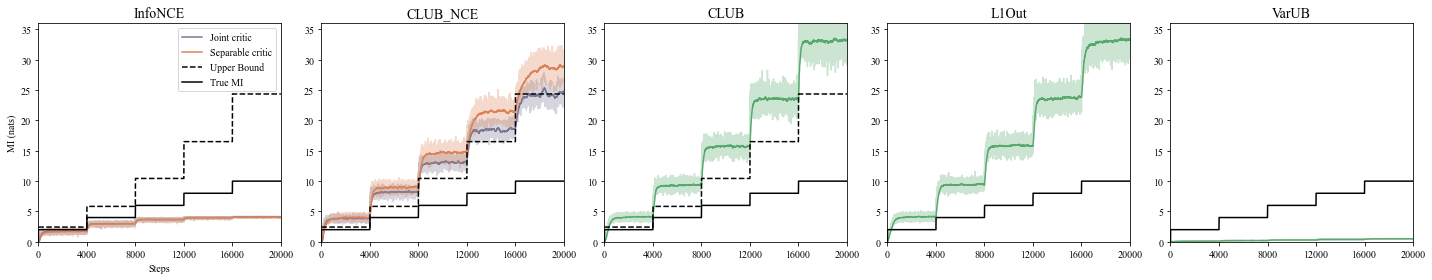

In [9]:

model_list = ['infonce','club_nce','club_gaus','l1out','vub']
ncols = len(model_list)

nrows = 1
EMA_SPAN = 200
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])

yaxis_upper = np.repeat(upper_list, 4000)

for i, estimator in enumerate(model_list):
    key = f'{estimator}'
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=14)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    plt.rc('font', family='Times New Roman')
    if estimator=='infonce' or estimator=='club_nce':

        for net in ['concat', 'separable']:
            mis = mi_numpys[net][key]
            if net == 'concat':
                p1 = plt.plot(mis,c='#787794', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
            if net == 'separable':
                p1 = plt.plot(mis,c='#dc8459', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)     
        plt.xticks(my_x_ticks)
        
        plt.plot(yaxis_upper, color='k', ls='--',label='Upper Bound')
        plt.plot(mi_true, color='k', label='True MI')
        if i == 0:
            plt.ylabel('MI (nats)')
            plt.xlabel('Steps')
            plt.legend()
            
            
    if estimator=='club_gaus':
        for net in ['club_gaus']:
            mis = mi_numpys[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)    
        plt.xticks(my_x_ticks)
        plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')

    if estimator=='l1out':
        for net in ['l1out']:
            mis = mi_numpys[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)    
        plt.xticks(my_x_ticks)
        plt.plot(mi_true, color='k', label='True MI')
    
    if estimator=='vub':
        for net in ['vub']:
            mis = mi_numpys[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)    
        plt.xticks(my_x_ticks)
        plt.plot(mi_true, color='k', label='True MI')


plt.gcf().tight_layout()


In [10]:
data_params = {
    'dim': dim,
    'batch_size': 64,
    'cubic': 1
}

critic_params = {
    'dim': dim,
    'layers': 1,
   'embed_dim': 32,
    'hidden_dim': 128,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 5e-4,
}

model_list = ['infonce','club_nce']
# Train for 20000 steps for each case.

mi_numpys_cubic = dict()
for critic_type in ['concat','separable']:
    mi_numpys_cubic[critic_type] = dict()
    for estimator in model_list:
        print(estimator)
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys_cubic[critic_type][f'{estimator}'] = mis
  
for critic_type in ['club_gaus']:
    mi_numpys_cubic[critic_type] = dict()
    for estimator in ['club_gaus']:
        print(estimator)
        critic_params = {
            'dim': dim,
            'layers': 1,
            'hidden_dim': 128,
            'activation': 'relu',
        }
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys_cubic[critic_type][f'{estimator}'] = mis

for critic_type in ['l1out']:
    mi_numpys_cubic[critic_type] = dict()
    for estimator in ['l1out']:
        print(estimator)
        critic_params = {
            'dim': dim,
            'hidden_size': 128,
        }
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys_cubic[critic_type][f'{estimator}'] = mis 
        
for critic_type in ['vub']:
    mi_numpys_cubic[critic_type] = dict()
    for estimator in ['vub']:
        print(estimator)
        critic_params = {
            'dim': dim,
            'hidden_size': 128,
        }
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params)
        mi_numpys_cubic[critic_type][f'{estimator}'] = mis 


infonce


100%|██████████| 20000/20000 [04:24<00:00, 75.71it/s]


club_nce


100%|██████████| 20000/20000 [04:21<00:00, 76.62it/s]


infonce


100%|██████████| 20000/20000 [01:08<00:00, 290.91it/s]


club_nce


100%|██████████| 20000/20000 [01:09<00:00, 285.96it/s]


club_gaus


100%|██████████| 20000/20000 [00:40<00:00, 490.39it/s]


l1out


100%|██████████| 20000/20000 [00:57<00:00, 346.25it/s]


vub


100%|██████████| 20000/20000 [00:23<00:00, 854.10it/s]


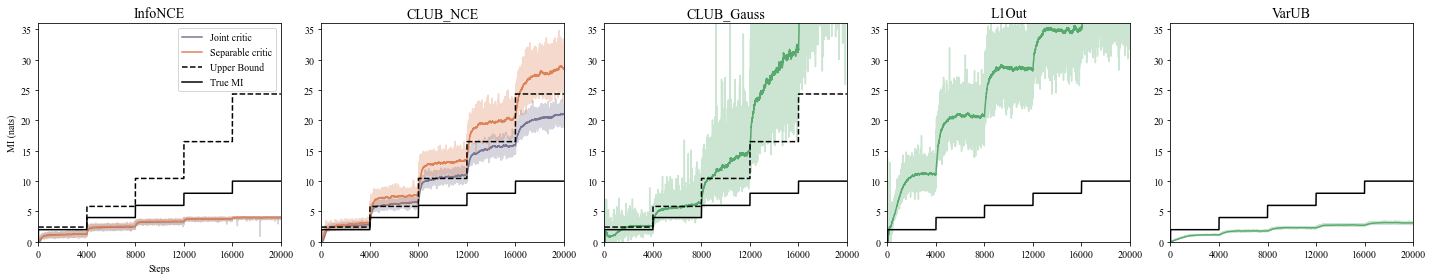

In [29]:

model_list = ['infonce','club_nce','club_gaus','l1out','vub']
ncols = len(model_list)

nrows = 1
EMA_SPAN = 200
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])

yaxis_upper = np.repeat(upper_list, 4000)
model_list = ['infonce','club_nce','club_gaus','l1out','vub']
for i, estimator in enumerate(model_list):
    key = f'{estimator}'
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=14)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    plt.rc('font', family='Times New Roman')
    if estimator=='infonce' or estimator=='club_nce':

        for net in ['concat', 'separable']:
            mis = mi_numpys_cubic[net][key]
            if net == 'concat':
                p1 = plt.plot(mis,c='#787794', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
            if net == 'separable':
                p1 = plt.plot(mis,c='#dc8459', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)    
        plt.xticks(my_x_ticks)
        
        plt.plot(yaxis_upper, color='k', ls='--',label='Upper Bound')
        plt.plot(mi_true, color='k', label='True MI')
        if i == 0:
            plt.ylabel('MI (nats)')
            plt.xlabel('Steps')
            plt.legend()
            
            
    if estimator=='club_gaus':
        for net in ['club_gaus']:
            mis = mi_numpys_cubic[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)     
        plt.xticks(my_x_ticks)
        plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')

    if estimator=='l1out':
        for net in ['l1out']:
            mis = mi_numpys_cubic[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)     
        plt.xticks(my_x_ticks)

        plt.plot(mi_true, color='k', label='True MI')
    
    if estimator=='vub':
        for net in ['vub']:
            mis = mi_numpys_cubic[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      
        plt.xticks(my_x_ticks)
        plt.plot(mi_true, color='k', label='True MI')


plt.gcf().tight_layout()


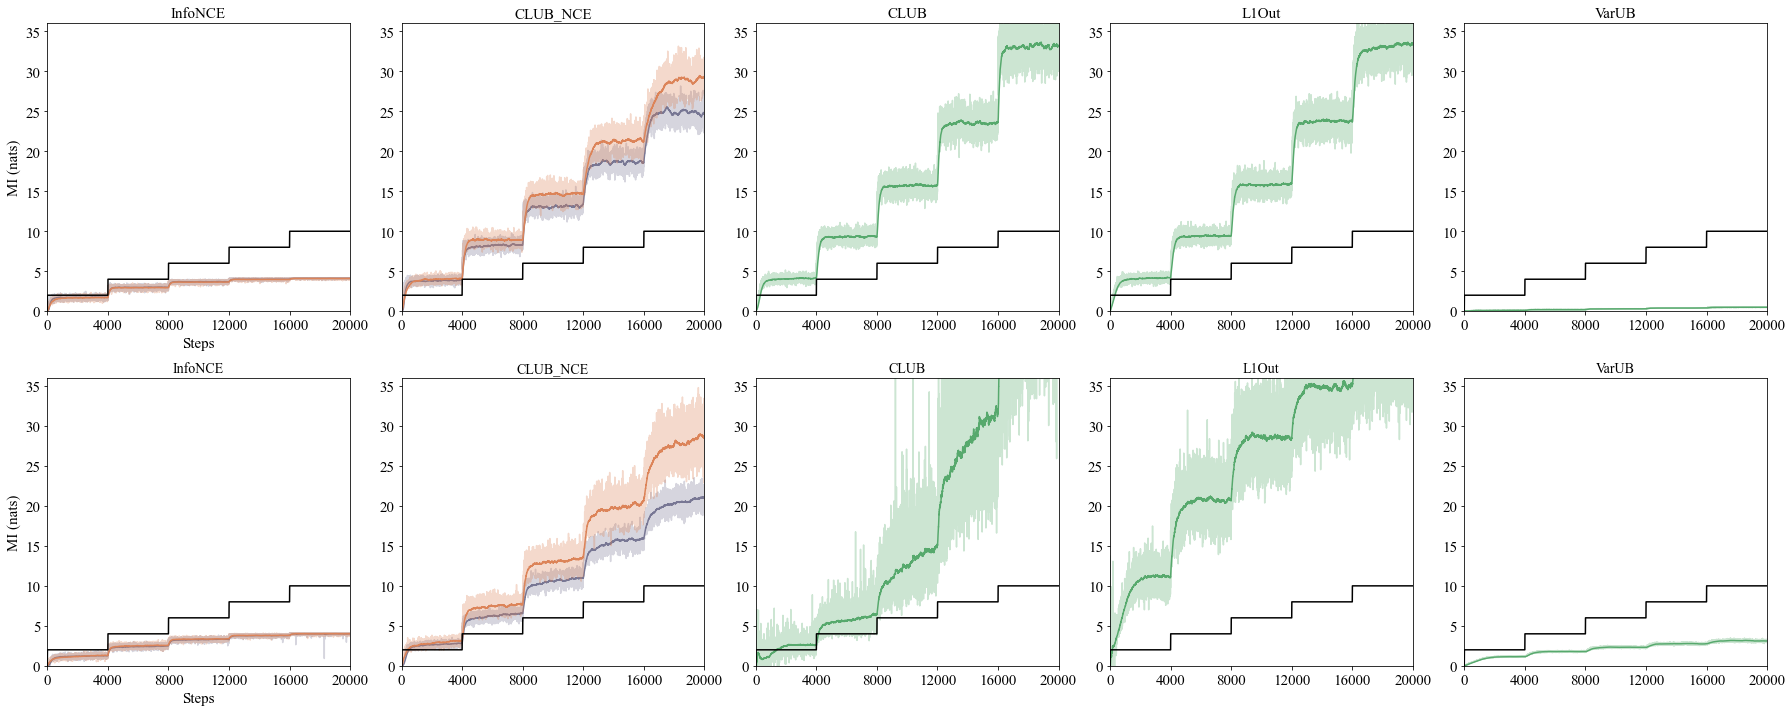

In [26]:
# Plot 5 of the results, InfoNCE, NWJ, Smile 1.0, 5.0, infty

ncols = 5
#model_list = ['club_0','club_1','club_2','club_3']
#model_list = ['estimators_32','estimators_64','estimators_128','estimators_256']
nrows = 2
EMA_SPAN = 200
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])

yaxis_upper = np.repeat(upper_list, 4000)
model_list = ['infonce','club_nce','club_gaus','l1out','vub']
for i, estimator in enumerate(model_list):
    key = f'{estimator}'
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=15)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    plt.rc('font', family='Times New Roman')
    if estimator=='infonce' or estimator=='club_nce':

        for net in ['concat', 'separable']:
            mis = mi_numpys[net][key]
            if net == 'concat':#ff7f0e，1f77b4
                p1 = plt.plot(mis,c='#787794', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
            if net == 'separable':
                p1 = plt.plot(mis,c='#dc8459', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
        
#         plt.plot(yaxis_upper, color='k', ls='--',label='Upper Bound')
        plt.plot(mi_true, color='k', label='True MI')
        if i == 0:
            plt.ylabel('MI (nats)',size=15)
            plt.xlabel('Steps',size=15)
            
            #plt.axhline(np.log(256), color='k', ls='--', label='log(bs)')
#             plt.legend()
            
            
    if estimator=='club_gaus':
        
        for net in ['club_gaus']:
            mis = mi_numpys[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
        
#         plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')

    if estimator=='l1out':
        
        for net in ['l1out']:
            mis = mi_numpys[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
        
#         plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')
    
    if estimator=='vub':
        for net in ['vub']:
            mis = mi_numpys[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
        
#         plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')





for i, estimator in enumerate(model_list):
    key = f'{estimator}'
    plt.sca(axs[i+5])
    plt.title(find_name(key), fontsize=14)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    plt.rc('font', family='Times New Roman')
    if estimator=='infonce' or estimator=='club_nce':

        for net in ['concat', 'separable']:
            mis = mi_numpys_cubic[net][key]
            if net == 'concat':#ff7f0e，1f77b4
                p1 = plt.plot(mis,c='#787794', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, color=p1.get_color())
                
            if net == 'separable':
                p1 = plt.plot(mis,c='#dc8459', alpha=0.3)[0]
                mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
                plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
        
#         plt.plot(yaxis_upper, color='k', ls='--',label='Upper Bound')
        plt.plot(mi_true, color='k', label='True MI')
        if i == 0:
            plt.ylabel('MI (nats)',size=15)
            plt.xlabel('Steps',size=15)
            #plt.axhline(np.log(256), color='k', ls='--', label='log(bs)')
#             plt.legend()
            
            
    if estimator=='club_gaus':
        for net in ['club_gaus']:
            mis = mi_numpys_cubic[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
#         plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')
    
    if estimator=='l1out':
        for net in ['l1out']:
            mis = mi_numpys_cubic[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
#         plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')
    
    if estimator=='vub':
        for net in ['vub']:
            mis = mi_numpys_cubic[net][key]
            p1 = plt.plot(mis,c='#57a96d', alpha=0.3)[0]
            mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
        plt.ylim(0, 36)
        plt.xlim(0, 20000)
        my_x_ticks = np.arange(0, 20001, 4000)      #显示范围为0至20000，每4000显示一刻度
        plt.xticks(my_x_ticks,size=15)
        
        my_y_ticks = np.arange(0, 37, 5)      #显示范围为0至20000，每4000显示一刻度
        plt.yticks(my_y_ticks,size=15)
        
        
#         plt.plot(yaxis_upper, color='k', ls='--')
        plt.plot(mi_true, color='k', label='True MI')

plt.gcf().tight_layout()

